In [45]:
import pandas as pd

# Part 1 specific
import sqlalchemy
from pathlib import Path

# Part 2 specific
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn import utils
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import tree
# ignore the warning you might get from importing ensemble from sklearn
from sklearn import ensemble

players = pd.read_csv("/Users/HuyVu/Desktop/ChallengeLab/cl_repo/AmazoogleChallengeLab/pac12_2019_players.csv")
teams = pd.read_csv("/Users/HuyVu/Desktop/ChallengeLab/cl_repo/AmazoogleChallengeLab/pac12_2019_teams.csv")
all_teams = pd.read_csv("/Users/HuyVu/Desktop/ChallengeLab/cl_repo/AmazoogleChallengeLab//data/all_teams_2019.csv")

In [46]:
all_teams

,Unnamed: 0,abbreviation,assist_percentage,assists,away_losses,away_wins,block_percentage,blocks,conference,conference_losses,...,total_rebound_percentage,total_rebounds,true_shooting_percentage,turnover_percentage,turnovers,two_point_field_goal_attempts,two_point_field_goal_percentage,two_point_field_goals,win_percentage,wins
0,ABILENE-CHRISTIAN,ABILENE-CHRISTIAN,58.5,525,4,10,8.0,93,southland,4,...,50.3,1110,0.565,15.5,407,1251,0.516,646,0.794,27
1,AIR-FORCE,AIR-FORCE,54.1,434,9,3,5.8,57,mwc,10,...,50.1,1077,0.541,17.4,423,1065,0.533,568,0.438,14
2,AKRON,AKRON,50.1,399,10,1,8.9,106,mac,10,...,48.2,1204,0.515,15.0,388,1019,0.491,500,0.515,17
3,ALABAMA-AM,ALABAMA-AM,52.3,385,18,0,4.7,50,swac,14,...,47.1,1032,0.479,19.4,487,1231,0.450,554,0.156,5
4,ALABAMA-BIRMINGHAM,ALABAMA-BIRMINGHAM,44.3,401,6,6,7.5,82,cusa,8,...,52.7,1279,0.536,14.8,399,1309,0.513,672,0.571,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,WRIGHT-STATE,WRIGHT-STATE,54.7,484,8,5,6.1,72,horizon,5,...,52.3,1229,0.543,14.6,402,1210,0.499,604,0.600,21
349,WYOMING,WYOMING,48.0,331,11,1,7.9,88,mwc,14,...,44.7,983,0.534,18.6,450,936,0.472,442,0.250,8
350,XAVIER,XAVIER,56.3,519,8,4,10.6,128,big-east,9,...,53.4,1281,0.553,16.5,450,1237,0.547,677,0.543,19
351,YALE,YALE,56.3,503,5,8,11.2,131,ivy,4,...,52.9,1157,0.584,15.9,392,1178,0.563,663,0.733,22


In [47]:
all_teams_train, all_teams_test = train_test_split(all_teams,test_size = 0.2,random_state = 100)

In [48]:
team_columns_wanted = ["abbreviation","assists","blocks","conference","field_goal_percentage","free_throw_percentage",
                   "free_throw_attempts","losses","net_rating","name","offensive_rating","offensive_rebounds",
                   "opp_assists","opp_field_goal_percentage","opp_offensive_rating","opp_three_point_field_goal_percentage",
                   "pace","points","three_point_field_goal_percentage","three_point_field_goal_attempts","total_rebounds",
                   "true_shooting_percentage","turnover_percentage","two_point_field_goal_percentage","wins","win_percentage"
                  ]
def get_desired_columns_from_df(df, columns_wanted):
    return df[team_columns_wanted]


def normalize_data(df):
    ## Select mean and std
    team_desc = df.describe().loc['mean':'std']
    team_means = team_desc.loc['mean']
    team_std = team_desc.loc['std']
    
    # teams_selected_columns.iloc[:,1:]
    values_useful = df.copy()
    values_useful.index = values_useful['abbreviation']
    values_useful = values_useful.drop(['abbreviation','name', 'conference'], axis=1)
    return (((values_useful - team_means) / team_std), team_means, team_std)




In [49]:
selected_cols_all_team = get_desired_columns_from_df(all_teams_train, team_columns_wanted)
normalized_all_team, all_team_mean, all_team_std = normalize_data(selected_cols_all_team)
normalized_all_team

,assists,blocks,field_goal_percentage,free_throw_percentage,free_throw_attempts,losses,net_rating,offensive_rating,offensive_rebounds,opp_assists,...,pace,points,three_point_field_goal_percentage,three_point_field_goal_attempts,total_rebounds,true_shooting_percentage,turnover_percentage,two_point_field_goal_percentage,wins,win_percentage
abbreviation,,,,,,,,,,,,,,,,,,,,,
CANISIUS,0.348961,-0.025602,-0.327632,-0.413294,-0.562519,0.217508,-0.822535,-0.387235,-0.461454,-0.473332,...,-0.389769,-0.577368,-0.791706,0.475287,-1.157678,-0.272610,0.141643,0.434384,-0.315906,-0.245107
MICHIGAN,1.008546,1.284160,0.199166,-0.154104,-0.523653,-1.754750,1.795980,0.491606,-0.477573,-1.006442,...,-1.498936,0.704476,-0.068268,0.902818,1.161717,0.026810,-2.249133,0.373877,2.057598,1.778093
ORAL-ROBERTS,-0.109880,-0.057547,0.523349,-0.442093,-1.368982,1.006411,-1.038847,0.095266,0.102717,1.089231,...,-0.175092,-0.324944,0.735553,-0.032406,-0.158935,0.288802,0.783071,0.313370,-0.948841,-0.984580
LIBERTY,1.295322,-0.408946,1.779558,1.977009,-1.058057,-1.754750,1.978138,1.577234,-0.945029,-1.263805,...,-1.498936,1.016063,1.016890,1.205653,0.063925,2.047894,-0.616408,2.279844,1.899364,1.748514
BETHUNE-COOKMAN,0.033508,-0.025602,-0.165540,-2.774798,0.545154,0.217508,0.042713,-0.869737,1.392251,0.133310,...,1.685446,-0.419603,-0.912280,-0.914189,0.889333,-1.021160,1.307876,-0.231192,-0.474140,-0.345675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DREXEL,0.320284,-1.495090,0.685440,1.343435,-0.475071,0.611960,-0.424065,0.801786,-0.268024,0.059778,...,0.146925,0.112855,0.414025,-0.611354,-0.332270,0.588222,-0.791343,0.343623,-0.632373,-0.617801
WICHITA-STATE,0.822142,0.836924,-1.421750,0.537068,0.214795,-0.176944,0.122407,-0.387235,1.988660,-0.032138,...,-0.103532,0.838577,-1.354381,1.357070,2.069666,-1.395435,-0.849654,-1.048035,0.791729,0.500283
UTAH-VALLEY,0.607060,-0.632564,1.576944,0.537068,1.273886,-1.163073,0.862422,1.008572,-0.171309,0.556121,...,0.290043,1.185661,1.539374,0.021035,0.864571,1.748474,0.783071,1.160467,1.266430,1.204261


In [50]:
normalized_all_team.sort_values("win_percentage")

,assists,blocks,field_goal_percentage,free_throw_percentage,free_throw_attempts,losses,net_rating,offensive_rating,offensive_rebounds,opp_assists,...,pace,points,three_point_field_goal_percentage,three_point_field_goal_attempts,total_rebounds,true_shooting_percentage,turnover_percentage,two_point_field_goal_percentage,wins,win_percentage
abbreviation,,,,,,,,,,,,,,,,,,,,,
CHICAGO-STATE,-0.941530,-1.175636,-1.340704,-0.874075,-0.504221,2.584218,-3.828135,-3.127154,-1.235174,2.100301,...,0.862516,-1.681727,-1.796482,-2.374920,-1.413554,-2.069129,2.357485,-1.683358,-2.214709,-2.463527
SAN-JOSE-STATE,-0.267607,-1.814544,-1.583841,-1.478851,-0.125280,2.189766,-2.678265,-2.058758,-0.090713,2.026769,...,0.612059,-1.397749,-0.630942,-0.860747,-0.299254,-1.694854,1.657746,-1.743865,-2.056476,-2.256475
MAINE,0.420655,-0.472837,-0.449200,-1.680443,-1.757640,2.189766,-1.687784,-1.662418,-0.783838,1.070848,...,-1.785172,-1.610732,-1.314190,-0.807306,-1.248473,-1.096015,1.716057,-0.019418,-1.898242,-2.096748
NEW-HAMPSHIRE,-1.672808,-1.782599,-2.718482,-2.774798,-2.408640,1.598089,-1.630859,-2.437866,-1.106221,-2.642537,...,-0.890683,-2.580990,-0.470178,0.439660,-1.487841,-2.518259,0.025020,-2.681722,-1.898242,-2.002096
KENNESAW-STATE,-1.142273,-0.089492,-2.515867,-0.326897,-0.416773,1.992540,-2.302565,-2.506795,0.699126,1.438510,...,0.468941,-1.445078,-1.314190,-2.668848,-0.026870,-3.191954,0.141643,-3.135523,-1.740009,-1.907443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WOFFORD,1.237967,-0.121438,1.901127,-0.067708,-0.543086,-2.149202,2.581535,2.680095,0.586292,-0.638780,...,-0.389769,1.903493,2.825487,1.704439,0.542662,2.122749,-1.549394,1.281480,2.057598,2.050219
BUFFALO,2.256021,0.996651,0.766486,-0.557288,1.303035,-2.346428,1.887059,1.577234,1.988660,-1.098357,...,1.757005,2.526667,-0.269223,2.532781,2.507132,0.737932,-1.374459,1.614268,2.374065,2.239524
GONZAGA,3.245398,3.041157,3.359950,1.573826,1.536229,-2.346428,3.446783,3.197060,0.408981,-1.263805,...,0.755177,3.339159,0.775744,0.466380,2.284272,2.946153,-1.782640,3.278208,2.532299,2.257272


In [51]:
training_columns_wanted = ["assists","blocks","field_goal_percentage","free_throw_percentage",
                       "free_throw_attempts","net_rating","offensive_rating","offensive_rebounds",
                       "opp_assists","opp_field_goal_percentage","opp_offensive_rating","opp_three_point_field_goal_percentage",
                       "pace","points","three_point_field_goal_percentage","three_point_field_goal_attempts","total_rebounds",
                       "true_shooting_percentage","turnover_percentage","two_point_field_goal_percentage"
                      ]

In [52]:
model = LinearRegression()
X_train = normalized_all_team[training_columns_wanted]
Y_train = normalized_all_team["wins"]

test_selected_columns = get_desired_columns_from_df(all_teams_test,team_columns_wanted)
X_predict,X_predict_mean,X_predict_std = normalize_data(test_selected_columns)
X_predict = X_predict[training_columns_wanted]

model.fit(X_train,Y_train)
y_hat = model.predict(X_predict)
y_true,test_mean,test_std = normalize_data(test_selected_columns)
y_true = y_true['wins']


MSE :  0.06692125637214115
MAE :  0.2079599950078736


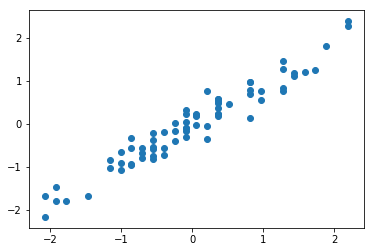

In [53]:
mse = mean_squared_error(y_true,y_hat)
mae = mean_absolute_error(y_true,y_hat)
plt.scatter(y_true, y_hat)
print("MSE : ", mse)
print("MAE : ",mae)

In [54]:
(y_true * all_team_std['win_percentage']) + all_team_mean['win_percentage']

abbreviation
OKLAHOMA                0.572104
CENTRAL-FLORIDA         0.675133
TEXAS-CHRISTIAN         0.649375
CALIFORNIA-RIVERSIDE    0.314534
GRAMBLING               0.494833
                          ...   
RIDER                   0.469076
SOUTH-ALABAMA           0.494833
BROWN                   0.572104
TEXAS-AM                0.417562
TULANE                  0.159992
Name: wins, Length: 71, dtype: float64

In [55]:
(y_hat * all_team_std['win_percentage']) + all_team_mean['win_percentage']

array([0.54826816, 0.6390144 , 0.67444786, 0.36686244, 0.56728374,
       0.71128227, 0.5878729 , 0.72426839, 0.41712065, 0.57450919,
       0.32784345, 0.48176383, 0.59156479, 0.38352742, 0.39895405,
       0.20616199, 0.60436394, 0.91611548, 0.53404294, 0.39025426,
       0.33573142, 0.48400543, 0.51351952, 0.54617617, 0.3567022 ,
       0.60259635, 0.65382478, 0.6078096 , 0.22654764, 0.54218592,
       0.63962499, 0.54189016, 0.5504658 , 0.62821402, 0.72619813,
       0.34799843, 0.44960237, 0.47482659, 0.26355734, 0.37426703,
       0.71648492, 0.42145023, 0.41587172, 0.81616998, 0.41415625,
       0.45437331, 0.41358713, 0.75855477, 0.50226518, 0.64588534,
       0.49323224, 0.50619219, 0.6745606 , 0.37491669, 0.89556724,
       0.64211088, 0.46059332, 0.39805468, 0.20879512, 0.51653046,
       0.47939498, 0.35120673, 0.60721501, 0.14331162, 0.70042055,
       0.54957947, 0.44521516, 0.49464839, 0.55153215, 0.44938324,
       0.22819075])

In [56]:
not_normal_model = LinearRegression()
team_selected_columns = get_desired_columns_from_df(all_teams_train,team_columns_wanted)
X_train2 = team_selected_columns[training_columns_wanted]
Y_train2 = team_selected_columns['wins']

not_normal_model.fit(X_train2,Y_train2)
test_selected_columns = get_desired_columns_from_df(all_teams_test,team_columns_wanted)
X_predict2 = test_selected_columns[training_columns_wanted]

y_hat2 = not_normal_model.predict(X_predict2)
y_true2 = test_selected_columns['wins']


MSE :  2.82453414235889
MAE :  1.3490064849551544


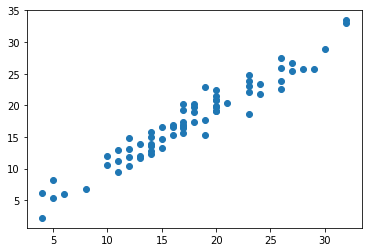

In [57]:
mse2 = mean_squared_error(y_true2,y_hat2)
mae2 = mean_absolute_error(y_true2,y_hat2)
plt.scatter(y_true2, y_hat2)
print("MSE : ", mse2)
print("MAE : ",mae2)

In [58]:
players.columns.unique()

Index(['Unnamed: 0', '_player_id', '_name', '_height', '_weight', '_position',
       '_season', '_team_abbreviation', '_minutes_played', '_total_rebounds',
       '_player_efficiency_rating', '_field_goal_percentage',
       '_free_throw_percentage', '_two_point_percentage',
       '_three_point_percentage', '_offensive_rebounds', '_assists',
       '_turnovers', '_usage_percentage', '_offensive_win_shares',
       '_defensive_rebounds', '_steals', '_blocks', '_defensive_win_shares'],
      dtype='object')

In [61]:
all_teams_train

,Unnamed: 0,abbreviation,assist_percentage,assists,away_losses,away_wins,block_percentage,blocks,conference,conference_losses,...,total_rebound_percentage,total_rebounds,true_shooting_percentage,turnover_percentage,turnovers,two_point_field_goal_attempts,two_point_field_goal_percentage,two_point_field_goals,win_percentage,wins
47,CANISIUS,CANISIUS,58.4,466,5,9,9.7,108,maac,7,...,47.3,1026,0.534,16.4,412,1043,0.520,542,0.469,15
178,MICHIGAN,MICHIGAN,54.4,512,4,7,10.3,149,big-ten,5,...,50.7,1307,0.542,12.3,334,1263,0.518,654,0.811,30
235,ORAL-ROBERTS,ORAL-ROBERTS,50.8,434,13,3,9.4,107,summit,9,...,52.1,1147,0.549,17.5,447,1140,0.516,588,0.344,11
149,LIBERTY,LIBERTY,55.2,532,3,11,8.1,96,atlantic-sun,2,...,51.5,1174,0.596,15.1,395,1104,0.581,641,0.806,29
23,BETHUNE-COOKMAN,BETHUNE-COOKMAN,53.3,444,12,3,8.8,108,meac,7,...,52.1,1274,0.514,18.4,501,1264,0.498,629,0.452,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,DREXEL,DREXEL,53.1,464,11,3,4.9,62,colonial,11,...,51.9,1126,0.557,14.8,377,1231,0.517,637,0.406,13
343,WICHITA-STATE,WICHITA-STATE,53.7,499,7,7,10.3,135,aac,8,...,52.1,1417,0.504,14.7,446,1387,0.471,653,0.595,22
323,UTAH-VALLEY,UTAH-VALLEY,52.0,484,8,8,6.7,89,wac,4,...,53.1,1271,0.588,17.5,487,1189,0.544,647,0.714,25
280,SOUTH-DAKOTA-STATE,SOUTH-DAKOTA-STATE,49.7,489,6,7,6.0,65,summit,2,...,53.3,1259,0.615,14.6,388,1163,0.565,657,0.727,24
